### 1. Import Libraries

In [33]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F 

import matplotlib.pyplot as plt
import time

import helper
from tqdm import tqdm

### 2. Load Data

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### 3. NN class - Init, Train and Validate

In [293]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

        
        
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader):
    #put model in training state
    model.train()
    
    running_loss = 0
    
    #pbar = tqdm(enumerate(train_loader), total = len(train_loader)+1)
    
    for (imgs, labels) in train_loader:
        imgs = imgs.view(imgs.shape[0], -1) #since we have a flat network right now
        
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss+= loss.item()
    print('Epoch {} avg Training loss: {:.3f}'.format(epoch, running_loss/len(train_loader)))
    
    return running_loss/len(train_loader)
        
def valid_one_epoch(epoch, model, loss_fn, test_loader):
    model.eval()
    
    #pbar = tqdm(enumerate(test_loader), total = len(test_loader))
    running_loss = 0
    actual_labels = []
    pred_labels = []
    
    for (imgs, labels) in test_loader:
        imgs = imgs.view(imgs.shape[0], -1) #since we have a flat network right now
        
        log_preds = model(imgs)
        loss = loss_fn(log_preds, labels)
        
        
        preds = torch.exp(log_preds)
        running_loss+=loss.item()
        
        #calculate accuracy
        top_prob, top_class = preds.topk(1, dim=1)
        pred_labels+= list((top_class.view(-1)).numpy())
        actual_labels+= list(labels.numpy())
        
        
    
    accuracy = ((np.array(pred_labels)==np.array(actual_labels)).sum())/10000 #size of test set
    print('Epoch {} avg Valid loss: {:.3f}'.format(epoch, running_loss/len(test_loader)))
    print('Epoch {} Valid accuracy: {:.1%}\n'.format(epoch, accuracy))
    
    return running_loss/len(test_loader)
    
        

In [308]:
model = Network()
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

### Train and save checkpoints

In [309]:
train_losses = []
valid_losses = []
for epoch in range(10):
    train_loss = train_one_epoch(epoch, model, loss_fn, optimizer, trainloader)
    train_losses+= [train_loss]
    valid_loss = valid_one_epoch(epoch, model, loss_fn, testloader)
    valid_losses+=[valid_loss]
    
    
    if len(valid_losses)>1 and (valid_loss<min(valid_losses[:-1])) :
        print(epoch)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            'transforms': transform
            }, 'Pytorch Training/checkpoint.tar')

Epoch 0 avg Training loss: 0.612
Epoch 0 avg Valid loss: 0.482
Epoch 0 Valid accuracy: 82.2%

Epoch 1 avg Training loss: 0.487
Epoch 1 avg Valid loss: 0.445
Epoch 1 Valid accuracy: 83.8%

1
Epoch 2 avg Training loss: 0.454
Epoch 2 avg Valid loss: 0.459
Epoch 2 Valid accuracy: 83.4%

Epoch 3 avg Training loss: 0.435
Epoch 3 avg Valid loss: 0.400
Epoch 3 Valid accuracy: 85.4%

3
Epoch 4 avg Training loss: 0.422
Epoch 4 avg Valid loss: 0.377
Epoch 4 Valid accuracy: 86.6%

4
Epoch 5 avg Training loss: 0.412
Epoch 5 avg Valid loss: 0.399
Epoch 5 Valid accuracy: 85.8%

Epoch 6 avg Training loss: 0.396
Epoch 6 avg Valid loss: 0.377
Epoch 6 Valid accuracy: 87.0%

6
Epoch 7 avg Training loss: 0.396
Epoch 7 avg Valid loss: 0.414
Epoch 7 Valid accuracy: 85.6%

Epoch 8 avg Training loss: 0.395
Epoch 8 avg Valid loss: 0.398
Epoch 8 Valid accuracy: 86.2%

Epoch 9 avg Training loss: 0.389
Epoch 9 avg Valid loss: 0.373
Epoch 9 Valid accuracy: 87.0%

9


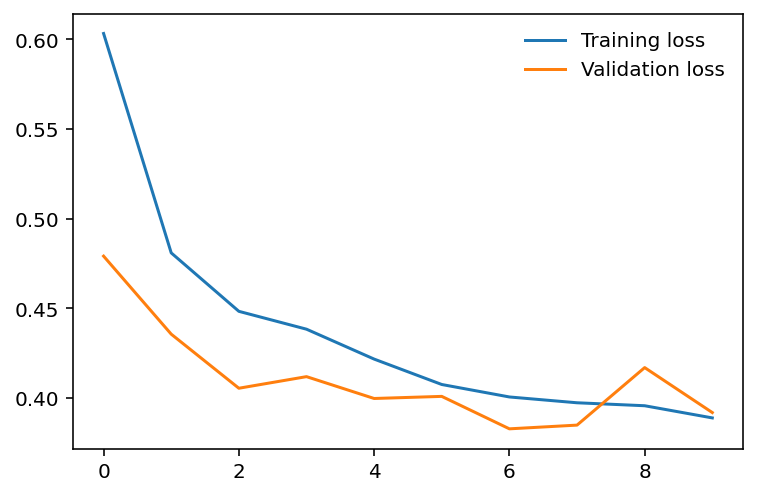

In [301]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [304]:
valid_losses[-2]

0.4170184508440601

In [305]:
valid_losses

[0.47917486053363534,
 0.43566818392960127,
 0.4055066340288539,
 0.41197188976843646,
 0.3997903132134942,
 0.40096338548857696,
 0.38286810999463317,
 0.3849425741062043,
 0.4170184508440601,
 0.39194374602691384]